In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from datetime import date, timedelta
from numpy import nan, isnan
from os import listdir as listdir, makedirs as makedirs, path as osp, remove as remove, sep as sep, walk as walk
from pandas import (
    CategoricalDtype, DataFrame, Index, NaT, Series, concat, get_dummies, isna, notnull, read_csv, read_excel,
    to_datetime, to_numeric
)
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
from matplotlib import colors as colors, pyplot as plt
import numpy as np
import os
import re
import statsmodels.api as sm

today = date.today()
encounter_layouts_list = ['Desert', 'Jungle', 'Submarine', 'Urban']
participant_count = 26


## Use the CSV Data from the CACI Logs (Human_Sim_Metrics_Data_4-12-2024)

In [3]:

# In the zip there are 51 folders, (51 JSON, 51 CSV).
# All the files are named appropriated in the folder/csv/json UUID_ParticipantID.
# Some of the internal Participants IDs might be off because the moderator forgot to enter a Participant ID or didn't enter
# the Participant ID correctly so we needed to figure out which participant it was.
# So only utilize the UUID and Participant ID that is on the file name to identify and ignore the internal Participant IDs.
print("\nGet all the Open World logs into one data frame")
csv_stats_df = DataFrame([])
logs_path = osp.join(nu.data_folder, 'logs', 'Human_Sim_Metrics_Data_4-12-2024')
directories_list = listdir(logs_path)
for dir_name in directories_list:
    
    # Add the CSVs to the data frame
    folder_path = osp.join(logs_path, dir_name)
    df = fu.concatonate_logs(logs_folder=folder_path)
    
    session_uuid, participant_id = dir_name.split('_')
    df['session_uuid'] = session_uuid
    df['participant_id'] = int(participant_id)
    
    # Remove numerically-named columns
    columns_list = [x for x in df.columns if not search(r'\d+', str(x))]
    df = df[columns_list]
    
    # Convert 'TRUE' and 'FALSE' to boolean values
    for cn in fu.boolean_columns_list:
        df[cn] = df[cn].map({'TRUE': True, 'FALSE': False, 'True': True, 'False': False})
    
    # Convert the nulls into NaNs
    for cn in df.columns: df[cn] = df[cn].replace(['null', 'nan', 'n'], nan)
    
    # Append the data frame for the current subdirectory to the main data frame and break the participant ID loop
    csv_stats_df = concat([csv_stats_df, df], axis='index')

csv_stats_df = csv_stats_df.reset_index(drop=True).drop_duplicates()
csv_stats_df['csv_file_name'] = csv_stats_df.csv_file_subpath.map(lambda x: str(x).split('/')[-1])

# Check for proper ingestion (duplicate file ingestion, et al)
assert len(csv_stats_df.columns) > 4, "Nothing ingested"
assert_str = f"Participant count should be {participant_count}, it's {csv_stats_df.participant_id.nunique()} instead"
assert csv_stats_df.participant_id.nunique() == participant_count, assert_str

# Check that all the rows that have more than one unique value in the file_name column for each value in the session_uuid column
mask_series = (csv_stats_df.groupby('session_uuid').csv_file_subpath.transform(Series.nunique) > 1)
assert not mask_series.any(), "You have duplicate files"

print(csv_stats_df.shape)
display(csv_stats_df.groupby('participant_id').size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))
display(csv_stats_df.sample(4).dropna(axis='columns', how='all').T.sample(5))


Get all the Open World logs into one data frame
(158663, 110)


,record_count
participant_id,
2024202,11231
2024211,10888
2024209,10503
2024224,10365
2024218,10261


,56734,100565,80243,135542
session_uuid,37a554ee-fc49-4730-819c-2d97727bb0b7,5d94f0d4-a1b1-4d18-8a62-591e196006a9,499179ba-3138-4bae-918e-ffc7fb943760,922ad146-241a-4ea6-8ff1-413d7e0d16ec
bag_access_location,"(0.0, 0.0, 0.0)",NaN,NaN,NaN
logger_version,1.4,1.4,1.4,1.4
participant_id,2024218,2024219,2024206,2024202
is_scene_aborted,False,False,False,False


In [4]:

# Remove the Unity suffix from all patient_id columns
# The one without "Root" is the ID that CACI sets for it. Unity
# then takes the ID and adds "Root" to the end when it
# creates the hierarchy, so there's less room for human
# error. They're going to match perfectly.
for cn in fu.patient_id_columns_list:
    if cn in csv_stats_df.columns:
        mask_series = ~csv_stats_df[cn].isnull()
        csv_stats_df.loc[mask_series, cn] = csv_stats_df[mask_series][cn].map(lambda x: str(x).replace(' Root', ''))

In [5]:

# Modalize separate patient ID columns into one
new_column_name = 'patient_id'
patient_id_columns_list = sorted(set(fu.patient_id_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, patient_id_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
patient_id,
Open World Marine 1 Female,2321
Patient V,2068
Patient U,1907
Patient X,1026
Patient W,1015


In [6]:

# Modalize separate patient SORT columns into one
new_column_name = 'patient_sort'
patient_sort_columns_list = sorted(set(fu.patient_sort_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, patient_sort_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
patient_sort,
still,1066
waver,670
walker,336


In [7]:

# Modalize separate injury severity columns into one
new_column_name = 'injury_severity'
injury_severity_columns_list = sorted(set(fu.injury_severity_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, injury_severity_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
injury_severity,
medium,1020
high,966
low,110


In [8]:

# Modalize separate location ID columns into one
new_column_name = 'location_id'
location_id_columns_list = sorted(set(fu.location_id_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, location_id_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
location_id,
"(0.0, 0.0, 0.0)",2675
"(15.1, 0.0, -27.9)",2102
"(-19.6, 0.0, -10.0)",1053
"(-22.5, 0.0, -10.7)",843
"(-3.3, 0.0, 0.0)",824


In [9]:

# Modalize separate injury ID columns into one
new_column_name = 'injury_id'
injury_id_columns_list = sorted(set(fu.injury_id_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, injury_id_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
injury_id,
L Leg Broken,179
R Forearm Burn,151
L Shoulder Broken,138
Unspecified,136
R Shoulder Puncture,131


In [10]:

# Modalize separate injury required procedure columns into one
new_column_name = 'injury_required_procedure'
injury_required_procedure_columns_list = sorted(set(fu.injury_required_procedure_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, injury_required_procedure_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
injury_required_procedure,
burnDressing,539
splint,478
tourniquet,353
woundpack,334
none,162


In [11]:

# Modalize separate patient SALT columns into one
new_column_name = 'patient_salt'
patient_salt_columns_list = sorted(set(fu.patient_salt_columns_list).intersection(set(csv_stats_df.columns)))
csv_stats_df = nu.modalize_columns(csv_stats_df, patient_salt_columns_list, new_column_name)
display(csv_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
patient_salt,
DELAYED,767
IMMEDIATE,674
EXPECTANT,373
MINIMAL,258



### Truncate the CSV data to only include our patients at the times they were engaged

In [12]:

# Add the sim environment column
new_column_name = 'encounter_layout'
if new_column_name not in csv_stats_df.columns:
    for (session_uuid, scene_id), scene_df in csv_stats_df.groupby(fu.scene_groupby_columns):
        mask_series = ~scene_df.patient_id.isnull()
        spl = sorted(scene_df[mask_series].patient_id.unique())
        for env_str in encounter_layouts_list:
    
            # Assume no Unity suffix
            patients_list = eval(f'fu.{env_str.lower()}_patients_list')
            if all(map(lambda p: p in spl, patients_list)):
                
                csv_stats_df.loc[scene_df.index, new_column_name] = env_str
    display(csv_stats_df.groupby([new_column_name], dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

,record_count
encounter_layout,
Desert,40678
Jungle,25582
Submarine,50198
Urban,42150
NaN,55


In [13]:

# Filter out the unnamed layouts
old_column_name = 'encounter_layout'
if old_column_name in csv_stats_df.columns:
    mask_series = csv_stats_df[old_column_name].isin(encounter_layouts_list)
    pre_count = csv_stats_df.shape[0]
    csv_stats_df = csv_stats_df[mask_series]
    print(f"\nFiltered out {pre_count - csv_stats_df.shape[0]} unnamed encounter layouts")
    display(csv_stats_df.groupby([old_column_name], dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ))
    assert_str = f"Participant count should be {participant_count}, it's {csv_stats_df.participant_id.nunique()} instead"
    assert csv_stats_df.participant_id.nunique() == participant_count, assert_str


Filtered out 55 unnamed encounter layouts


,record_count
encounter_layout,
Desert,40678
Jungle,25582
Submarine,50198
Urban,42150


In [14]:

# Create a list of patients that CACI doesn't care about
patients_set = set(fu.desert_patients_list + fu.jungle_patients_list + fu.submarine_patients_list + fu.urban_patients_list)
mask_series = ~csv_stats_df.patient_id.isnull()
all_set = set(csv_stats_df[mask_series].patient_id)
assert patients_set.issubset(all_set), f"You're missing {patients_set.difference(all_set)} from the patients in the CSVs"
mask_series = ~csv_stats_df.patient_id.isin(patients_set) & ~csv_stats_df.patient_id.isnull()
non_patients_list = csv_stats_df[mask_series].patient_id.unique().tolist()
print(f"My TA1 patients list is {nu.conjunctify_nouns(non_patients_list)}.")

My TA1 patients list is patient U, patient V, patient W, patient X, electrician, bystander, Player, Simulation, Patient V, Patient U, Patient W, Adept Victim, Adept Shooter, Patient X, NPC 2, NPC 1, NPC 3, NPC 4, Submarine Level Core, US Soldier 1, Local Soldier 1, Civilian 1, NPC, Civilian 2, Urban Level Core, and Desert Level Core.


In [15]:

# Build a dataset of each CSV file and the action tick where TA3 patients first appear
# Get the time difference between the first TELEPORT (the bag 
# close/teleport time before they interacted with the FIRST patient in 
# the freeform scenario) and last TELEPORT (or SESSION_END). This 
# involves less estimating the teleport nearest the layout start position.
rows_list = []
for csv_file_name, csv_file_name_df in csv_stats_df.groupby('csv_file_name'):
    row_dict = {'csv_file_name': csv_file_name}

    # Get the action tick closest to the JSON base point for this scenario
    action_tick, euclidean_distance = fu.get_action_tick_by_encounter_layout(csv_file_name_df, verbose=False)
    row_dict['nearest_tick_to_scenario_begin'] = action_tick
    row_dict['euclidean_distance_to_scenario_begin'] = euclidean_distance
    
    # Get last teleport time (assumes TA3 scenario is last)
    mask_series = csv_file_name_df.action_type.isin(['TELEPORT', 'SESSION_END'])
    if mask_series.any():
        last_teleport_time = csv_file_name_df[mask_series].action_tick.max()
        row_dict['last_teleport_time'] = last_teleport_time

    # Get the CACI patients mask
    patients_mask_series = csv_file_name_df.patient_id.isin(patients_set)

    # Get the first occurence of a CACI patient
    first_occurence = csv_file_name_df[patients_mask_series].action_tick.min()
    row_dict['first_occurence'] = first_occurence

    # Get the interaction with the last patient in the freeform scenario
    mask_series = csv_file_name_df.action_type.isin(fu.responder_negotiations_list) & patients_mask_series
    if mask_series.any():
        last_patient_interaction = csv_file_name_df[mask_series].action_tick.max()
        row_dict['last_patient_interaction'] = last_patient_interaction
    
    # Get the interaction with the FIRST patient in the freeform scenario
    mask_series = csv_file_name_df.action_type.isin(fu.responder_negotiations_list + ['PATIENT_ENGAGED']) & patients_mask_series
    if mask_series.any():
        first_patient_interaction = csv_file_name_df[mask_series].action_tick.min()
        row_dict['first_patient_interaction'] = first_patient_interaction
        
        # Get first teleport time
        mask_series = (csv_file_name_df.action_tick <= first_patient_interaction) & csv_file_name_df.action_type.isin(['TELEPORT'])
        if mask_series.any():
            first_teleport_time = csv_file_name_df[mask_series].action_tick.max()
            row_dict['first_teleport_time'] = first_teleport_time
    
    rows_list.append(row_dict)
first_occurence_df = DataFrame(rows_list)
columns_to_max = ['first_patient_interaction', 'first_teleport_time', 'first_occurence', 'nearest_tick_to_scenario_begin']
first_occurence_df['scene_transition_end'] = first_occurence_df[columns_to_max].max(axis='columns')
print(first_occurence_df.shape)
# print(sorted(first_occurence_df.columns))
columns_list = [
    'first_patient_interaction', 'nearest_tick_to_scenario_begin', 'first_teleport_time', 'first_occurence', 'scene_transition_end'
]
means_dict = {col: first_occurence_df[col].mean() for col in columns_list}
sorted_by_value = sorted(means_dict.items(), key=lambda item: item[1], reverse=True)
ordered_keys = [item[0] for item in sorted_by_value]
mask_series = False
for cn in columns_list: mask_series |= first_occurence_df[cn].isnull()
df = first_occurence_df[mask_series][ordered_keys]
display(df.sample(min(df.shape[0], 10)))

(51, 9)


,first_teleport_time,scene_transition_end,first_patient_interaction,nearest_tick_to_scenario_begin,first_occurence
16,NaN,60545.0,NaN,60545,15333
21,NaN,535649.0,30063.0,535649,30063
25,NaN,591056.0,NaN,591056,26866
47,NaN,107867.0,NaN,107867,17301
22,NaN,550238.0,NaN,550238,27394
44,NaN,277865.0,NaN,277865,44625
29,NaN,649511.0,24142.0,649511,24142
43,NaN,699546.0,17801.0,699546,17801


In [16]:

# From each file, filter out the time before the first appearance of the TA3 patients
truncated_csv_stats_df = DataFrame([])
for (csv_file_name, first_time, last_time), _ in first_occurence_df.groupby(
    # ['csv_file_name', 'first_occurence', 'last_teleport_time']
    ['csv_file_name', 'scene_transition_end', 'last_teleport_time']
):
    mask_series = (csv_stats_df.csv_file_name == csv_file_name)
    mask_series &= (csv_stats_df.action_tick >= first_time)
    mask_series &= (csv_stats_df.action_tick <= last_time)
    df = csv_stats_df[mask_series]
    truncated_csv_stats_df = concat([truncated_csv_stats_df, df], axis='index')
print(truncated_csv_stats_df.shape) # (137063, 118)
# display(truncated_csv_stats_df.sample(4).T)
assert_str = f"Participant count should be {participant_count}, it's {truncated_csv_stats_df.participant_id.nunique()} instead"
assert truncated_csv_stats_df.participant_id.nunique() == participant_count, assert_str

(48491, 118)


In [17]:

# Filter out just the patients that CACI doesn't care about
mask_series = ~truncated_csv_stats_df.patient_id.isin(non_patients_list)
truncated_csv_stats_df = truncated_csv_stats_df[mask_series]
print(truncated_csv_stats_df.shape) # (124046, 117)
assert_str = f"Participant count should be {participant_count}, it's {truncated_csv_stats_df.participant_id.nunique()} instead"
assert truncated_csv_stats_df.participant_id.nunique() == participant_count, assert_str

(47924, 118)


In [18]:

# Save the csv stats dataset
nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}truncated_csv_stats_df': csv_stats_df}, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240522truncated_csv_stats_df.csv



## Create the Scene Data

In [19]:

# Create the scene data frame precursor
distance_delta_df = fu.get_distance_deltas_data_frame(truncated_csv_stats_df)
print(distance_delta_df.shape) # (67, 16)
# display(distance_delta_df.sample(4).T)
display(distance_delta_df.groupby('patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

(54, 16)


,record_count
patient_count,
0,6
1,2
2,7
3,9
4,21
5,9


In [20]:

# Filter out the low patient counts
old_column_name = 'patient_count'
if old_column_name in distance_delta_df.columns:
    mask_series = distance_delta_df[old_column_name] >= 4
    pre_count = distance_delta_df.shape[0]
    distance_delta_df = distance_delta_df[mask_series]
    print(f"\nFiltered out {pre_count - distance_delta_df.shape[0]} low patient counts")
    display(distance_delta_df.groupby([old_column_name], dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ))


Filtered out 24 low patient counts


,record_count
patient_count,
4,21
5,9


In [21]:

def get_mean_tool_indecision_time(scene_df, verbose=False):
    
    # They'll be a series of TOOL_HOVERs, then a TOOL_SELECTED
    scene_df = scene_df.reset_index(drop=True)
    mask_series = (scene_df.action_type == 'TOOL_SELECTED')
    tool_selected_indices = scene_df[mask_series].index
    
    # Split based on index changes before TOOL_SELECTED rows
    split_indices = [0] + list(tool_selected_indices[:-1] + 1) + [len(scene_df)]

    # Gather the sub-dataframes in a list
    split_dfs = []
    for i in range(len(split_indices) - 1):
        start_index = split_indices[i]
        end_index = split_indices[i + 1]
        split_dfs.append(scene_df.iloc[start_index:end_index])
    
    # Get a list of times between the first TOOL_HOVER and the TOOL_SELECTED
    indecision_times_list = []
    for split_df in split_dfs:
        mask_series = (split_df.action_type == 'TOOL_HOVER')
        if mask_series.any():
            df = split_df[mask_series]
            indecision_times_list.append(split_df.action_tick.max() - df.action_tick.min())
    
    # Get the mean time of the list
    mean_tool_indecision_time = np.mean(indecision_times_list)

    return mean_tool_indecision_time

In [22]:

# Create the scene stats data frame
rows_list = []
for (session_uuid, scene_id), idx_df in distance_delta_df.groupby(fu.scene_groupby_columns):
    row_dict = list(idx_df.T.to_dict().values())[0]
    
    # mean_patient_count
    patient_count = row_dict.pop('patient_count')
    row_dict.update({'scene_patient_count': patient_count})
    
    # Get the whole scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (truncated_csv_stats_df[cn] == eval(cn))
    scene_df = truncated_csv_stats_df[mask_series]
    
    if scene_df.shape[0]:
        row_dict['participant_id'] = scene_df.participant_id.iloc[0]
        
        # Get the count of all the patient injuries
        all_patient_injuries_count = 0
        for patient_id, patient_df in scene_df.groupby('patient_id'):
            all_patient_injuries_count += patient_df.injury_id.nunique()
        row_dict['scene_patient_injuries_count'] = all_patient_injuries_count
        
        # percent_injury_correctly_treated
        correctly_treated_count = fu.get_injury_correctly_treated_count(scene_df)
        row_dict['scene_correctly_treated_count'] = correctly_treated_count
        try: percent_injury_correctly_treated = 100 * correctly_treated_count / all_patient_injuries_count
        except ZeroDivisionError: percent_injury_correctly_treated = nan
        row_dict['scene_percent_injury_correctly_treated'] = percent_injury_correctly_treated
        
        # mean_pulse_taken_count
        pulse_taken_count = fu.get_pulse_taken_count(scene_df)
        row_dict['scene_pulse_taken_count'] = pulse_taken_count
        
        # mean_stills_value
        row_dict['scene_stills_value'] = fu.get_stills_value(scene_df)
        
        # mean_teleport_count
        row_dict['scene_teleport_count'] = fu.get_teleport_count(scene_df)
        
        # mean_time_to_hemorrhage_control_per_patient
        row_dict['scene_time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
        
        # mean_triage_time
        row_dict['scene_triage_time'] = fu.get_triage_time(scene_df)
        
        # mean_tool_indecision_time
        row_dict['scene_tool_indecision_time'] = get_mean_tool_indecision_time(scene_df)
        
        # total_action_count
        mask_series = scene_df.action_type.isin(['PULSE_TAKEN', 'TOOL_APPLIED', 'TAG_APPLIED'])
        row_dict['scene_action_count'] = scene_df[mask_series].shape[0]

        # total_discarded_count
        mask_series = scene_df.action_type.isin(['TAG_DISCARDED', 'TOOL_DISCARDED'])
        row_dict['scene_discarded_count'] = scene_df[mask_series].shape[0]
        
        # total_assessment_count
        mask_series = scene_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['scene_assessment_count'] = scene_df[mask_series].shape[0]
        
        # total_treatment_count
        mask_series = scene_df.action_type.isin(['INJURY_TREATED'])
        row_dict['scene_treatment_count'] = scene_df[mask_series].shape[0]
        
        # total_tag_application_count
        mask_series = scene_df.action_type.isin(['TAG_APPLIED'])
        row_dict['scene_tag_application_count'] = scene_df[mask_series].shape[0]
    
    rows_list.append(row_dict)
scene_stats_df = DataFrame(rows_list).drop_duplicates()
print(scene_stats_df.shape) # (37, 29)
# display(scene_stats_df.sample(3).T)
display(scene_stats_df.groupby('scene_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

(30, 31)


,record_count
scene_patient_count,
4,21
5,9


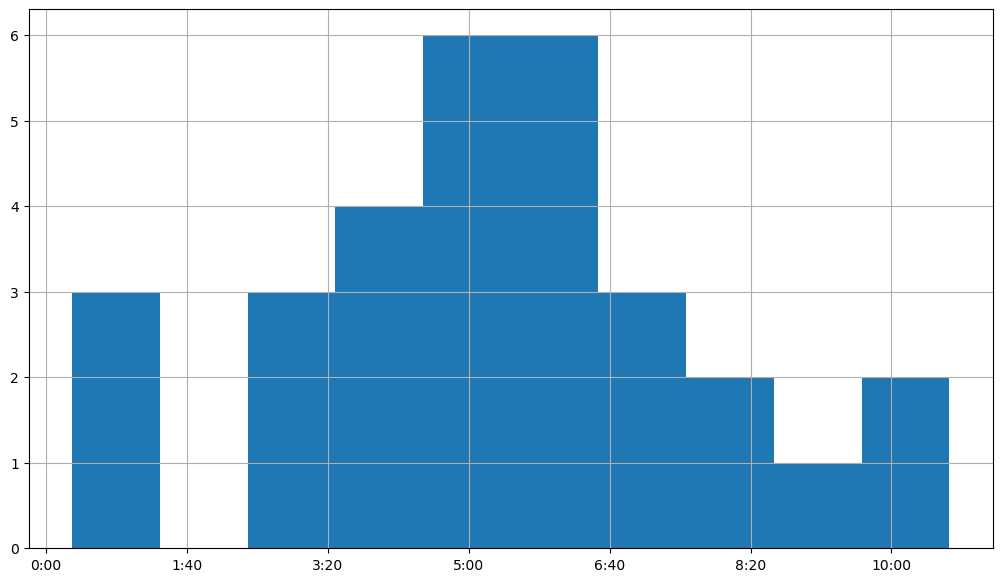

In [52]:

temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes')
fig_height = 7
fig_size=(nu.twitter_aspect_ratio*fig_height, fig_height)
fig, ax = plt.subplots(figsize=fig_size)
scene_stats_df.scene_triage_time.hist(ax=ax)

# Humanize x tick labels; why you have to set them twice (I do not know)
ax.set_xticklabels([text_obj for text_obj in ax.get_xticklabels()]);
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(temporalize_fn(text_obj.get_position()[0]))
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list);

In [24]:

# Add the sim environment column
new_column_name = 'encounter_layout'
if new_column_name not in scene_stats_df.columns:
    for (session_uuid, scene_id), scene_df in csv_stats_df.groupby(fu.scene_groupby_columns):
        mask_series = ~scene_df.patient_id.isnull()
        spl = sorted(scene_df[mask_series].patient_id.unique())
        for env_str in encounter_layouts_list:
    
            # Assume no Unity suffix
            patients_list = eval(f'fu.{env_str.lower()}_patients_list')
            if all(map(lambda p: p in spl, patients_list)):
                
                mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
                scene_stats_df.loc[mask_series, new_column_name] = env_str
    display(scene_stats_df.groupby([new_column_name, 'scene_patient_count'], dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ))

,,record_count
encounter_layout,scene_patient_count,
Desert,4,11
Jungle,4,3
Submarine,4,7
Urban,5,9



### Add the mean % accurate tagging column

In [25]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_data_frame(truncated_csv_stats_df, groupby_column='participant_id')
assert tag_to_salt_df.max_salt.dropna().shape[0] > 0, "You have to add the patient_salt column to truncated_csv_stats_df"
display(tag_to_salt_df.sample(5))

,session_uuid,scene_id,patient_id,participant_id,patient_count,last_tag,max_salt,predicted_tag,is_tag_correct
87,fc676b00-9559-467d-adbb-696dd6e9fb08,0,Open World Civilian 2 Female,2024213,1,gray,EXPECTANT,gray,True
117,45365e18-6e38-48e7-b4a2-6b448b209034,0,Marine 2 Male,2024218,1,NaN,IMMEDIATE,red,False
164,703b9d0b-7786-4a4b-8a26-7c57d16b785a,0,Marine 1 Male,2024226,1,red,EXPECTANT,gray,False
159,0e8693a1-1926-4d56-b0c4-ee2dc8181fc6,0,Open World Civilian 1 Male,2024226,1,red,DELAYED,yellow,False
104,c6d3a90f-68c0-4948-bd96-537e80973605,0,Navy Soldier 3 Male,2024216,1,NaN,IMMEDIATE,red,False


In [26]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='participant_id')
display(correct_count_by_tag_df.sample(5))

,session_uuid,scene_id,participant_id,percentage_tag_correct
23,5d94f0d4-a1b1-4d18-8a62-591e196006a9,0,2024219,50.0
11,23081f6e-875e-44f5-8bd0-edc3905f5c2c,3,2024201,0.0
8,23081f6e-875e-44f5-8bd0-edc3905f5c2c,0,2024201,40.0
34,a7ce6f7b-6466-4281-9496-92b640d9d04b,0,2024215,75.0
17,45365e18-6e38-48e7-b4a2-6b448b209034,0,2024218,60.0


In [27]:

# Group the scene stats by participant ID to get the tagging accuracy measure
for participant_id, idx_df in scene_stats_df.groupby('participant_id'):
    
    # mean_percent_accurate_tagging
    mask_series = (correct_count_by_tag_df.participant_id == participant_id)
    scene_stats_df.loc[idx_df.index, 'mean_percent_accurate_tagging'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()


### Add the treated-expectant count column

In [28]:

# Loop through each patient to build the max salt and treated-expectant measures
assert 'patient_salt' in truncated_csv_stats_df.columns, "You have to add the patient_salt column to truncated_csv_stats_df"
rows_list = []
for (session_uuid, scene_id, patient_id), patient_df in truncated_csv_stats_df.groupby(fu.patient_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
    row_dict['max_salt'] = fu.get_max_salt(patient_df, session_uuid=session_uuid, scene_id=scene_id, random_patient_id=patient_id)[1]
    if (row_dict['max_salt'] == 'EXPECTANT'):
        mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
        row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
    else: row_dict['treated_expectant'] = nan
    rows_list.append(row_dict)
treated_expectant_df = DataFrame(rows_list)
display(treated_expectant_df.sample(5))

,session_uuid,scene_id,patient_id,max_salt,treated_expectant
136,bccb0095-5efd-4c5c-ad58-8b8624f9ab56,0,Open World Civilian 1 Male,DELAYED,NaN
147,c99de80f-15cc-45cb-aa64-5af0f2f118ca,0,Open World Marine 2 Male,IMMEDIATE,NaN
36,23081f6e-875e-44f5-8bd0-edc3905f5c2c,2,Open World Civilian 2 Female,EXPECTANT,no
92,6a76af00-56ef-408f-a445-6f5168e090a8,0,Open World Marine 2 Male,IMMEDIATE,NaN
125,acf74a81-a534-44c7-9cb1-67ec381b5ee0,0,Navy Soldier 2 Male,IMMEDIATE,NaN


In [29]:

# Loop through each scene to build the treated-expectant counts
for (session_uuid, scene_id), scene_df in treated_expectant_df.groupby(fu.scene_groupby_columns):
    mask_series = (scene_df.treated_expectant == 'yes')
    
    # treated_expectant_count
    treated_expectant_count = mask_series.sum()
    mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
    scene_stats_df.loc[mask_series, 'treated_expectant_count'] = treated_expectant_count

In [30]:

# Add the survey columns
survey_columns = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text']
if any(map(lambda x: x not in scene_stats_df.columns, survey_columns)):
    file_path = osp.join(nu.data_folder, 'xlsx', 'participant_data_0420.xlsx')
    participant_data_df = read_excel(file_path).rename(columns={'ParticipantID': 'participant_id'})
    print(participant_data_df.shape)
    display(participant_data_df.sample(12).T)
    
    print("\nColumns to merge the participant data with the scene stats on:")
    on_columns = sorted(set(scene_stats_df.columns).intersection(set(participant_data_df.columns)))
    assert on_columns, "You have nothing to merge the participant dataset with the scene stats on"
    print(on_columns)

    print("\nThe participant data columns we want to have in the merge:")
    survey_set = set(on_columns + survey_columns)
    all_set = set(participant_data_df.columns)
    assert survey_set.issubset(all_set), f"You're missing {survey_set.difference(all_set)} from participant_data_0420.xlsx"
    columns_list = sorted(survey_set)
    print(columns_list)
    
    # mean_AD_KDMA_Sim
    # mean_AD_KDMA_Text
    # mean_PropTrust
    # mean_ST_KDMA_Sim
    # mean_ST_KDMA_Text
    df = participant_data_df[columns_list]
    print(scene_stats_df.shape)
    print(df.shape)
    scene_stats_df = scene_stats_df.merge(df, how='left', on=on_columns)
    print(scene_stats_df.shape)
    display(scene_stats_df.groupby(survey_columns, dropna=False).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
        'record_count', ascending=False
    ).head())

(26, 163)


,1,20,9,14,4,6,5,19,11,13,25,12
participant_id,2024202,2024222,2024211,2024216,2024205,2024207,2024206,2024221,2024213,2024215,2024227,2024214
Date,2024-03-14 00:00:00,2024-03-23 00:00:00,2024-03-20 00:00:00,2024-03-20 00:00:00,2024-03-14 00:00:00,2024-03-14 00:00:00,2024-03-14 00:00:00,2024-03-24 00:00:00,2024-03-20 00:00:00,2024-03-20 00:00:00,2024-04-05 00:00:00,2024-03-20 00:00:00
MedRole,5.0,6.0,2.0,NaN,6.0,1.0,1.0,6.0,6.0,6.0,5.0,NaN
MedExp,2.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
MilitaryExp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
ST_Align_LOW_text,0.363179,0.288707,0.348785,0.434783,0.315152,0.353858,0.468247,0.371962,0.35132,0.31783,0.38765,0.34797
ST_Align_HIGH_sim,0.348326,0.400454,0.405731,0.344827,0.42389,0.341044,0.408258,0.368191,0.314834,0.361009,0.272968,0.345243
ST_Align_LOW_sim,0.202062,0.231824,0.241932,0.296899,0.254944,0.40638,0.172197,0.325467,0.301237,0.245353,0.362257,0.204622
ST_Align_HIGH_Four,0.391551,0.465159,0.33661,0.332492,0.331343,0.347934,0.397956,0.388033,0.425376,0.306278,0.291602,0.356846



Columns to merge the participant data with the scene stats on:
['participant_id']

The participant data columns we want to have in the merge:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'participant_id']
(30, 34)
(26, 6)
(30, 39)


,,,,,record_count
AD_KDMA_Sim,AD_KDMA_Text,PropTrust,ST_KDMA_Sim,ST_KDMA_Text,
0.341667,0.416667,3.666667,0.558333,0.421212,5
0.316667,0.366667,3.666667,0.533333,0.461864,2
0.416667,0.416667,4.000000,0.500000,0.398858,2
0.533333,0.366667,4.000000,0.529807,0.529864,2
0.475000,0.466667,2.333333,0.643357,0.387654,2



### Truncate the scene data to only include our patients at the times they were engaged

In [31]:

# Filter out the unnamed layouts
old_column_name = 'encounter_layout'
if old_column_name in scene_stats_df.columns:
    mask_series = scene_stats_df[old_column_name].isin(encounter_layouts_list)
    pre_count = scene_stats_df.shape[0]
    scene_stats_df = scene_stats_df[mask_series]
    print(f"\nFiltered out {pre_count - scene_stats_df.shape[0]} unnamed encounter layouts")
    display(scene_stats_df.groupby([old_column_name, 'scene_patient_count'], dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ))
    assert_str = f"Participant count should be {participant_count}, it's now {scene_stats_df.participant_id.nunique()}"
    if scene_stats_df.participant_id.nunique() != participant_count: print(assert_str)


Filtered out 0 unnamed encounter layouts


,,record_count
encounter_layout,scene_patient_count,
Desert,4,11
Jungle,4,3
Submarine,4,7
Urban,5,9


Participant count should be 26, it's now 17


In [32]:

# Check for zero teleports
mask_series = (scene_stats_df.scene_teleport_count < 1)
print(f"\nThere are {scene_stats_df[mask_series].shape[0]} out of {scene_stats_df.shape[0]} scenes with no teleports")


There are 0 out of 30 scenes with no teleports


In [33]:

# Save the scene stats dataset
nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}truncated_scene_stats_df': scene_stats_df}, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240522truncated_scene_stats_df.csv



## Create the ANOVA Dataframe

In [34]:

# Get the columns to merge the scene stats dataset with the CSV stats on
print("\nColumns to merge the scene stats dataset with the CSV stats on:")
on_columns = sorted(set(csv_stats_df.columns).intersection(set(scene_stats_df.columns)))
print(on_columns)


Columns to merge the scene stats dataset with the CSV stats on:
['encounter_layout', 'participant_id', 'scene_id', 'session_uuid']


In [35]:

# Get the scene stats dataset columns we want to have in the merge
print('\nThe scene stats dataset columns we want to have in the merge:')
mean_analysis_columns = sorted([
    'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count',
    'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time', 'scene_tool_indecision_time', 'scene_patient_count',
    'mean_percent_accurate_tagging'
] + survey_columns)
sum_analysis_columns = sorted([
    'scene_action_count', 'scene_discarded_count', 'scene_assessment_count', 'scene_treatment_count', 'scene_tag_application_count',
    'treated_expectant_count'
])
analysis_set = set(mean_analysis_columns + sum_analysis_columns)
all_set = set(scene_stats_df.columns)
assert analysis_set.issubset(all_set), f"You're missing {analysis_set.difference(all_set)} from your analysis_columns"
print(analysis_set)


The scene stats dataset columns we want to have in the merge:
{'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time', 'ST_KDMA_Sim', 'scene_action_count', 'scene_percent_injury_correctly_treated', 'scene_tag_application_count', 'ST_KDMA_Text', 'scene_patient_count', 'scene_tool_indecision_time', 'scene_stills_value', 'PropTrust', 'scene_assessment_count', 'mean_percent_accurate_tagging', 'AD_KDMA_Text', 'AD_KDMA_Sim', 'treated_expectant_count', 'scene_treatment_count', 'scene_pulse_taken_count', 'scene_discarded_count', 'scene_teleport_count'}


In [36]:

# Merge the scene stats with the CSV stats
print("\nMerge the scene stats with the CSV stats")
columns_list = on_columns + mean_analysis_columns + sum_analysis_columns
assert set(columns_list).issubset(set(scene_stats_df.columns)), "You've lost access to the analysis columns"
df = scene_stats_df[columns_list]
print(csv_stats_df.shape)
print(df.shape)
merge_df = csv_stats_df.merge(df, on=on_columns, how='left').drop_duplicates()
print(merge_df.shape)
# display(merge_df.sample(4).T)
display(merge_df.groupby('scene_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))


Merge the scene stats with the CSV stats
(158608, 118)
(30, 24)
(158608, 138)


,record_count
scene_patient_count,
4.0,73306
5.0,32537
NaN,52765


In [37]:

# Get the merge dataset columns we want to have in the groupby
print('\nThe merge dataset columns we want to have in the groupby:')
columns_list = sorted(set(
    on_columns + mean_analysis_columns + sum_analysis_columns
).intersection(set(merge_df.columns)))
print(columns_list)


The merge dataset columns we want to have in the groupby:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'encounter_layout', 'mean_percent_accurate_tagging', 'participant_id', 'scene_action_count', 'scene_assessment_count', 'scene_discarded_count', 'scene_id', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_tag_application_count', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_tool_indecision_time', 'scene_treatment_count', 'scene_triage_time', 'session_uuid', 'treated_expectant_count']


In [38]:

# Get the numeric columns we want to take the mean of
print("\nThe numeric columns we want to take the mean of:")
df = merge_df[on_columns + mean_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the mean analysis columns"
mean_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(mean_numeric_columns)


The numeric columns we want to take the mean of:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'mean_percent_accurate_tagging', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_tool_indecision_time', 'scene_triage_time']


In [39]:

# Get the numeric columns we want to take the sum of
print("\nThe numeric columns we want to take the sum of:")
df = merge_df[on_columns + sum_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the sum analysis columns"
sum_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(sum_numeric_columns)


The numeric columns we want to take the sum of:
['scene_action_count', 'scene_assessment_count', 'scene_discarded_count', 'scene_tag_application_count', 'scene_treatment_count', 'treated_expectant_count']


In [40]:

# Get the other columns we do not want to take the mean or sum of
print("\nThe other columns we do not want to take the mean or sum of:")
other_columns = sorted(set(on_columns + mean_analysis_columns + sum_analysis_columns).difference(set(
    mean_numeric_columns + sum_numeric_columns
)))
print(other_columns)


The other columns we do not want to take the mean or sum of:
['encounter_layout', 'participant_id', 'scene_id', 'session_uuid']


In [41]:

# Get the means and sums datasets and the columns to merge the summed half of the merge with the meaned half of the merge on
means_df = merge_df[mean_numeric_columns+on_columns].groupby(on_columns).mean().reset_index(drop=False).rename(
    columns={cn: 'mean_'+cn.replace('mean_', '').replace('scene_', '') for cn in mean_numeric_columns}
).dropna(axis='columns', how='all')
# display(means_df.sample(7).T)
# display(means_df.groupby('mean_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))
sums_df = merge_df[sum_numeric_columns+on_columns].groupby(on_columns).sum().reset_index(drop=False).rename(
    columns={cn: 'sum_'+cn.replace('sum_', '').replace('scene_', '') for cn in sum_numeric_columns}
).dropna(axis='columns', how='all')
# display(sums_df.sample(7).T)
print("\nColumns to merge the summed half of the merge with the meaned half of the merge on:")
on_columns = sorted(set(means_df.columns).intersection(set(sums_df.columns)))
print(on_columns)
print(means_df.shape)
print(sums_df.shape)
left_df = means_df.merge(sums_df, on=on_columns, how='outer').drop_duplicates()
print(left_df.shape)
# display(left_df.sample(7).T)
# display(left_df.groupby('mean_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))


Columns to merge the summed half of the merge with the meaned half of the merge on:
['encounter_layout', 'participant_id', 'scene_id', 'session_uuid']
(54, 18)
(54, 10)
(54, 24)


In [42]:

# Get the columns to merge the unaggregated half of the merge with the aggregated half of the merge on
right_df = merge_df[other_columns].drop_duplicates().dropna(axis='columns', how='all')
print(right_df.shape)
display(right_df.sample(5))
print("\nColumns to merge the unaggregated half of the merge with the aggregated half of the merge on:")
on_columns = sorted(set(left_df.columns).intersection(set(right_df.columns)))
print(on_columns)

(54, 4)


,encounter_layout,participant_id,scene_id,session_uuid
34811,Urban,2024201,0,23081f6e-875e-44f5-8bd0-edc3905f5c2c
82525,Desert,2024221,0,6a76af00-56ef-408f-a445-6f5168e090a8
63781,Jungle,2024203,0,4bc46c8c-66e7-463d-b3a1-2a8303af4fd1
48325,Urban,2024209,0,385032e9-9801-4dcf-a841-b3703a0d9acd
110550,Jungle,2024224,0,a3a7727b-dd25-4e78-8d63-e66573f5077e



Columns to merge the unaggregated half of the merge with the aggregated half of the merge on:
['encounter_layout', 'participant_id', 'scene_id', 'session_uuid']


In [43]:

# Merge the unaggregated half of the merge with the aggregated half
print(
    "\nAggregate the data from the merged datasets and group by participant, session,"
    " and scene to get the means and sums of the numeric columns"
)
print(left_df.shape)
print(right_df.shape)
anova_df = left_df.merge(right_df, on=on_columns, how='outer').drop_duplicates()
print(anova_df.shape)
display(anova_df.sample(7).T)
display(anova_df.groupby('mean_patient_count', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))
assert set(
    ['mean_'+cn for cn in survey_columns]
).issubset(set(anova_df.columns)), "You've lost acces to the survey columns (PropTrust, et al)"
assert len(anova_df.groupby(
    ['participant_id', 'scene_id', 'session_uuid']
).groups.keys()) == anova_df.shape[0], "You have duplicate rows in anova_df"


Aggregate the data from the merged datasets and group by participant, session, and scene to get the means and sums of the numeric columns
(54, 24)
(54, 4)
(54, 24)


,20,27,2,4,32,14,10
encounter_layout,Jungle,Jungle,Desert,Desert,Submarine,Desert,Desert
participant_id,2024212,2024227,2024201,2024202,2024211,2024226,2024218
scene_id,0,0,2,0,0,0,0
session_uuid,2e8f6555-a7fa-4b54-8132-c030d697b4ad,9f3bb117-3a4b-4bc7-9237-e2d9920d5333,23081f6e-875e-44f5-8bd0-edc3905f5c2c,922ad146-241a-4ea6-8ff1-413d7e0d16ec,02d472ac-f6fe-474c-815d-6125fadfcbf7,0e8693a1-1926-4d56-b0c4-ee2dc8181fc6,37a554ee-fc49-4730-819c-2d97727bb0b7
mean_AD_KDMA_Sim,NaN,NaN,0.341667,0.341667,0.5,0.316667,0.316667
mean_AD_KDMA_Text,NaN,NaN,0.416667,0.416667,0.475,0.366667,0.466667
mean_PropTrust,NaN,NaN,3.666667,4.333333,3.333333,3.666667,4.0
mean_ST_KDMA_Sim,NaN,NaN,0.558333,0.595513,0.634266,0.621795,0.58141
mean_ST_KDMA_Text,NaN,NaN,0.421212,0.434775,0.267488,0.48417,0.334622
mean_percent_accurate_tagging,NaN,NaN,13.0,32.5,37.5,45.0,42.5


,record_count
mean_patient_count,
4.0,21
5.0,9
NaN,24


In [44]:

# Add the sim environment back in
new_column_name = 'encounter_layout'
if new_column_name not in anova_df.columns:
    print("\nAdd the sim environment back in")
    on_columns = sorted(set(anova_df.columns).intersection(set(scene_stats_df.columns)))
    columns_list = on_columns + [new_column_name]
    assert set(columns_list).issubset(set(scene_stats_df.columns)), f"You've lost acces to the {new_column_name} column"
    df = scene_stats_df[columns_list]
    print(anova_df.shape)
    print(df.shape)
    anova_df = anova_df.merge(
        df, on=on_columns, how='left'
    )
    print(anova_df.shape)
    display(anova_df.groupby([new_column_name, 'mean_patient_count'], dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ).sort_values('record_count', ascending=False))

In [45]:

# Filter out the unnamed layouts
old_column_name = 'encounter_layout'
if old_column_name in anova_df.columns:
    mask_series = anova_df[old_column_name].isin(encounter_layouts_list)
    pre_count = anova_df.shape[0]
    anova_df = anova_df[mask_series]
    print(f"\nFiltered out {pre_count - anova_df.shape[0]} unnamed encounter layouts")
    display(anova_df.groupby([old_column_name, 'mean_patient_count'], dropna=False).size().to_frame().rename(
        columns={0: 'record_count'}
    ).sort_values('record_count', ascending=False))
    assert_str = f"Participant count should be {participant_count}, it's {anova_df.participant_id.nunique()} instead"
    assert anova_df.participant_id.nunique() == participant_count, assert_str


Filtered out 0 unnamed encounter layouts


record_count
encounter_layout mean_patient_count              
Desert           4.0                           11
Jungle           NaN                           10
Urban            5.0                            9
Submarine        4.0                            7
                 NaN                            6
Desert           NaN                            4
Urban            NaN                            4
Jungle           4.0                            3

In [46]:

# Check for low patient counts
mask_series = (anova_df.mean_patient_count < 4)
print(f"\nThere are {anova_df[mask_series].shape[0]} out of {anova_df.shape[0]} participations with low patient counts")


There are 0 out of 54 participations with low patient counts


In [47]:

# Store the results
columns_list = anova_df.columns.tolist()
nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}truncated_anova_df': anova_df[columns_list]}, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240522truncated_anova_df.csv


In [48]:

# Get statistics using OSU format
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'mean_tool_indecision_time', 'sum_action_count', 'sum_discarded_count', 'sum_assessment_count', 'sum_tag_application_count',
    'sum_treatment_count', 'sum_treated_expectant_count'
]
description_df = nu.get_statistics(anova_df, columns_list).T
# assert float(description_df.loc['mean_patient_count', 'min']) >= 4.0, "There are less than 4 patients in some scenes"

# Calculate range and IQR
description_df['range'] = description_df['max'] - description_df['min']
description_df['IQR'] = description_df['75%'] - description_df['25%']

# Define the index list
index_list = ['min', 'median', 'max', 'IQR', 'range', 'mean', 'SD']

# Set formatting to prevent scientific notation (assuming numeric columns)
description_df = description_df[index_list].applymap('{:.4f}'.format)  # Format as floats with 4 decimals

# Humanize the temporal and sum variables
temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=float(x)), minimum_unit='minutes')
for idx in ['mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time', 'mean_tool_indecision_time']:
    description_df.loc[idx] = description_df.loc[idx].map(temporalize_fn)
for idx in [idx for idx in description_df.index if idx.startswith('sum_')]:
    description_df.loc[idx] = description_df.loc[idx].map(lambda x: '{:,}'.format(int(float(x))))

# Save and show the description data frame
nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}description_df': description_df}, include_index=True, verbose=True)
display(description_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240522description_df.csv


,min,median,max,IQR,range,mean,SD
mean_AD_KDMA_Sim,0.3167,0.3917,0.8000,0.1250,0.4833,0.4131,0.1029
mean_AD_KDMA_Text,0.3167,0.4167,0.6250,0.1000,0.3083,0.4225,0.0786
mean_PropTrust,0.0000,3.6667,4.3333,0.3333,4.3333,3.4598,1.1070
mean_ST_KDMA_Sim,0.4923,0.5583,0.6434,0.0474,0.1510,0.5691,0.0418
mean_ST_KDMA_Text,0.2675,0.3989,0.5299,0.1073,0.2624,0.3940,0.0713
mean_percent_accurate_tagging,12.5000,42.5000,75.0000,39.0000,62.5000,40.4167,20.6621
mean_patient_count,4.0000,4.0000,5.0000,1.0000,1.0000,4.3000,0.4661
mean_percent_injury_correctly_treated,0.0000,73.2143,100.0000,19.0476,100.0000,74.3989,19.7675
mean_pulse_taken_count,0.0000,11.0000,26.0000,10.5000,26.0000,11.4667,7.7670
mean_stills_value,0.0000,1.0000,1.0000,1.0000,1.0000,0.5667,0.5040



# Plot the Correlations

In [49]:

# Define a means to plot a correlation graph
def plot_correlation_graph(correlations, title_str='Correlation Matrix', fig=None, ax=None):
    
    # Plotting the correlation matrix using matplotlib
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(vmin=-1, vmax=1)

    # Create the heatmap
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(correlations, cmap=cmap, norm=norm)

    # Add a color bar
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(correlations.columns)))
    ax.set_yticks(np.arange(len(correlations.columns)))
    ax.set_xticklabels(correlations.columns)
    ax.set_yticklabels(correlations.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')

    # Add text annotations.
    for (i, j), val in np.ndenumerate(correlations):
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=84/correlations.shape[0])
    plt.title(title_str)
    plt.show()

In [50]:

# Plot the correlations of all the numeric columns in the ANOVA dataset
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'mean_tool_indecision_time', 'sum_action_count', 'sum_discarded_count', 'sum_assessment_count', 'sum_tag_application_count',
    'sum_treatment_count', 'sum_treated_expectant_count'
]
# columns_list = ['mean_'+cn for cn in survey_columns]
df = anova_df[columns_list]
correlations_df = df.corr().round(3)
nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}correlations_df': correlations_df}, verbose=True)
display(correlations_df.sample(3).T)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240522correlations_df.csv


,mean_ST_KDMA_Text,sum_treatment_count,sum_action_count
mean_AD_KDMA_Sim,-0.006,0.055,0.049
mean_AD_KDMA_Text,-0.380,0.121,0.125
mean_PropTrust,0.299,-0.014,-0.003
mean_ST_KDMA_Sim,-0.079,0.392,0.456
mean_ST_KDMA_Text,1.000,-0.298,-0.213
mean_percent_accurate_tagging,-0.065,0.251,0.349
mean_patient_count,0.387,0.096,0.183
mean_percent_injury_correctly_treated,-0.035,0.012,0.003
mean_pulse_taken_count,-0.163,0.367,0.604
mean_stills_value,0.204,-0.132,-0.060


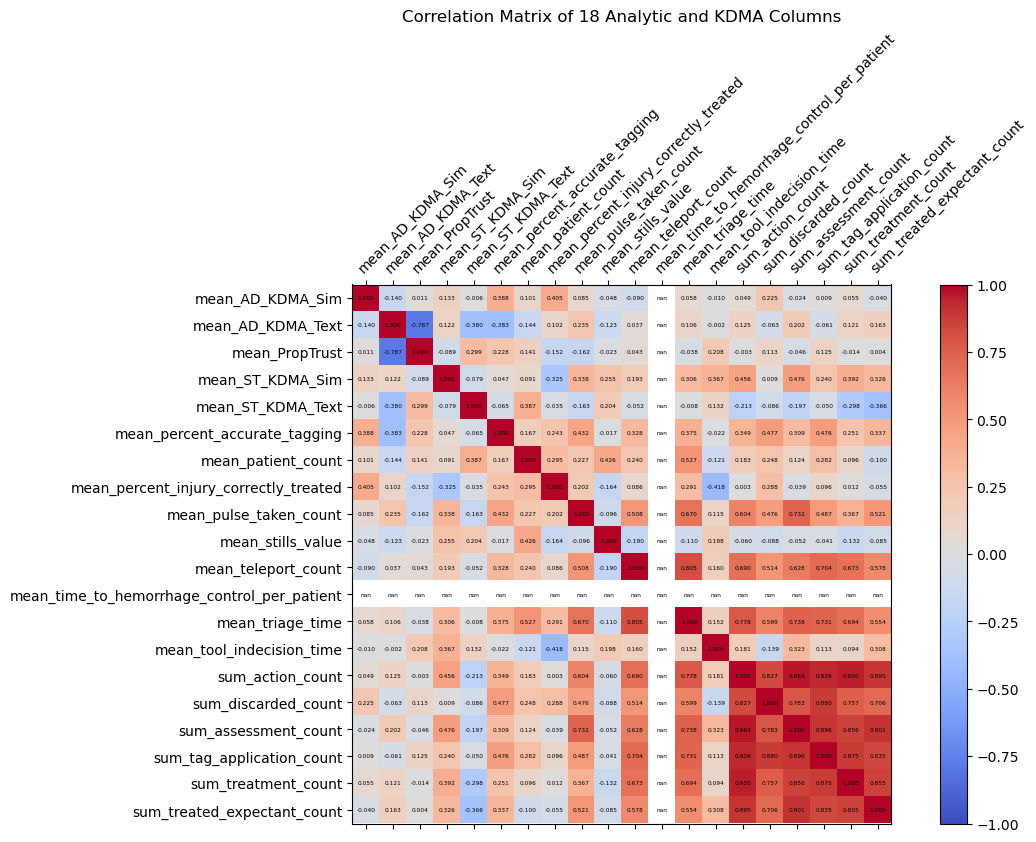

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/png/20240522correlation_matrix_of_18_analytic_and_kdma_columns.png
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/svg/20240522correlation_matrix_of_18_analytic_and_kdma_columns.svg


In [51]:

fig_height = 7
fig_size=(nu.twitter_aspect_ratio*fig_height, fig_height)
fig, ax = plt.subplots(figsize=fig_size)
title_str = "Correlation Matrix of 18 Analytic and KDMA Columns"
plot_correlation_graph(correlations_df, title_str=title_str, fig=fig, ax=ax)
dir_names_list=['png', 'svg']
for dir_name in dir_names_list:
    try:
        dir_path = osp.join(nu.saves_folder, dir_name)
        os.makedirs(name=dir_path, exist_ok=True)
        file_prefix = f'{today.year}{today.month:02d}{today.day:02d}'
        file_prefix += re.sub('[^A-Za-z0-9]+', '_', title_str).lower()
        file_path = osp.join(dir_path, '{}.{}'.format(file_prefix, dir_name))
        if osp.exists(file_path): os.remove(file_path)
        print(f'Saving to {osp.abspath(file_path)}')
        fig.savefig(file_path, bbox_inches='tight')
    except Exception as e:
        print(f'{e.__class__.__name__} error saving the figure as a {dir_name}: {str(e).strip()}')